In [ ]:
%pip install dtaidistance pyts python-Levenshtein

In [2]:
#IMPORTING LIBRARIES
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import coherence
from statsmodels.tsa.stattools import acf
from sklearn.utils import resample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import correlate
from scipy.signal import welch
from scipy.stats import f_oneway
from scipy.stats import linregress
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import euclidean
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy.stats import entropy
from Levenshtein import distance as lcs_distance
from sklearn.model_selection import train_test_split
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from sktime.datasets import load_arrow_head
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, pairwise_distances
from minisom import MiniSom
import matplotlib.pyplot as plt
from tslearn.piecewise import SymbolicAggregateApproximation

c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [65]:
def test():
    return 2,"works"

a,b = test()

In [66]:
a,b

(2, 'works')

In [67]:
# DISTANCES
def calculate_correlation(X, Y):
    correlation = np.corrcoef(X, Y)[0, 1]
    return correlation

def calculate_cross_correlation(X, Y):
    cross_corr = correlate(X, Y, mode='same')
    max_corr = np.max(cross_corr)
    return max_corr

def calculate_euclidean_distance(X, Y):
    distance = np.sqrt(np.sum((X - Y)**2))
    return distance

def calculate_dtw_distance(X, Y):
    distance = dtw.distance(X, Y)
    return distance

def calculate_cosine_similarity(X, Y):
    dot_product = np.dot(X, Y)
    magnitude_X = np.sqrt(np.sum(X**2))
    magnitude_Y = np.sqrt(np.sum(Y**2))
    similarity = dot_product / (magnitude_X * magnitude_Y)
    return similarity

def calculate_mutual_information(X, Y):
    return mutual_info_score(X, Y)

def calculate_lcs_distance(X, Y):
    m, n = len(X), len(Y)
    dp = [[0] * (n+1) for _ in range(m+1)]
    for i in range(1, m+1):
        for j in range(1, n+1):
            if X[i-1] == Y[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    lcs_distance = m + n - 2 * dp[m][n]
    return lcs_distance

def calculate_power_spectrum_distance(X, Y):
    _, X_power_spectrum = welch(X, nperseg=min(len(X), 256))
    _, Y_power_spectrum = welch(Y, nperseg=min(len(Y), 256))
    distance = np.sqrt(np.sum((X_power_spectrum - Y_power_spectrum)**2))
    return distance

def test_variance(X, Y):
    statistic, p_value = f_oneway(X, Y)
    return p_value

# def calculate_combined_distance(X, Y, weights):
#     distances = [
#         calculate_correlation(X, Y),
#         calculate_cross_correlation(X, Y),
#         calculate_euclidean_distance(X, Y),
#         calculate_dtw_distance(X, Y),
#         calculate_cosine_similarity(X, Y),
#         calculate_mutual_information(X, Y),
#         calculate_lcs_distance(X, Y),
#         calculate_hurst_exponent(X),
#         calculate_power_spectrum_distance(X, Y)
#     ]
#     combined_distance = np.dot(weights, distances)
#     return combined_distance


def calculate_relative_entropy(X,Y):
    '''
    Calculates the relative entropy of the cluster exemplar, Y,
    to the orginal signal, X
    '''
    return entropy(X)/entropy(Y)

# def calculate_sax_distance(X, Y, n_bins=4):
#     sax = SymbolicAggregateApproximation(n_segments=n_bins,alphabet_size_avg=n_bins*10)
#     X_sax = sax.transform(np.expand_dims(X, axis=0))
#     Y_sax = sax.transform(np.expand_dims(Y, axis=0))
#     return dtw(X_sax, Y_sax)

def calculate_edit_distance(X, Y, normalized=True):
    return lcs_distance(str(X), str(Y)) / max(len(X), len(Y)) if normalized else lcs_distance(str(X), str(Y))


# HYPOTHESIS TESTS
def autocorrelation_test(X, Y, alpha=0.05):
    """
    Perform autocorrelation test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    acf_X = acf(X, nlags=len(X))
    acf_Y = acf(Y, nlags=len(Y))
    _, p_value = stats.ttest_ind(acf_X, acf_Y)
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The autocorrelation structures of the two time series are significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The autocorrelation structures of the two time series are similar."

def waveform_distance_test(X, Y, alpha=0.05):
    """
    Perform waveform distance test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    distance_XY = dtw.distance(X, Y)
    distance_XX = dtw.distance(X, X)
    distance_YY = dtw.distance(Y, Y)
    test_statistic = (distance_XY - (distance_XX + distance_YY) / 2) / np.sqrt((distance_XX + distance_YY) / 2)
    p_value = stats.norm.sf(np.abs(test_statistic))
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The waveform distances of the two time series are significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The waveform distances of the two time series are similar."

# def bootstrap_test(X, Y, statistic, n_bootstrap=1000, alpha=0.05):
#     """
#     Perform bootstrap test on two time series.
    
#     Parameters:
#         X (array-like): First time series.
#         Y (array-like): Second time series.
#         statistic (function): Function to calculate the test statistic.
#         n_bootstrap (int, optional): Number of bootstrap iterations. Default is 1000.
#         alpha (float, optional): Significance level. Default is 0.05.
    
#     Returns:
#         str: Test result and interpretation.
#     """
#     np.random.seed(0)
#     X_bootstrap = resample(X, replace=True, n_samples=len(X))
#     Y_bootstrap = resample(Y, replace=True, n_samples=len(Y))
#     test_statistic_X = statistic(X_bootstrap)
#     test_statistic_Y = statistic(Y_bootstrap)
#     bootstrap_statistics = []
#     for _ in range(n_bootstrap):
#         X_bootstrap = resample(X, replace=True, n_samples=len(X))
#         Y_bootstrap = resample(Y, replace=True, n_samples=len(Y))
#         bootstrap_statistics.append(test_statistic(X_bootstrap) - test_statistic(Y_bootstrap))
#     p_value = np.mean(np.abs(bootstrap_statistics) >= np.abs(test_statistic_X - test_statistic_Y))
#     if p_value < alpha:
#         return "Reject the null hypothesis. The two time series are significantly different based on the bootstrap test."
#     else:
#         return "Fail to reject the null hypothesis. The two time series are similar based on the bootstrap test."

def kolmogorov_smirnov_test(X, Y, alpha=0.05):
    """
    Perform Kolmogorov-Smirnov test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    _, p_value = stats.ks_2samp(X, Y)
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The two time series are significantly different based on the Kolmogorov-Smirnov test."
    else:
        return p_value,"Fail to reject the null hypothesis. The two time series are similar based on the Kolmogorov-Smirnov test."

def spectral_coherence_test(X, Y, fs, alpha=0.05):
    """
    Perform spectral coherence test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        fs (float): Sampling frequency of the time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    _, coherence_values = coherence(X, Y, fs=fs)
    test_statistic = np.mean(coherence_values)
    p_value = 1 - stats.chi2.cdf(test_statistic, df=len(coherence_values))
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The spectral coherence of the two time series is significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The spectral coherence of the two time series is similar."

def nonlinear_measures_test(X, Y, alpha=0.05):
    """
    Perform nonlinear measures test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    distance_XY = lcss(X, Y)
    distance_XX = lcss(X, X)
    distance_YY = lcss(Y, Y)
    test_statistic = (distance_XY - (distance_XX + distance_YY) / 2) / np.sqrt((distance_XX + distance_YY) / 2)
    p_value = stats.norm.sf(np.abs(test_statistic))
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The nonlinear measures of the two time series are significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The nonlinear measures of the two time series are similar."

def state_space_modeling_test(X, Y, alpha=0.05):
    """
    Perform state space modeling test on two time series.
    
    Parameters:
        X (array-like): First time series.
        Y (array-like): Second time series.
        alpha (float, optional): Significance level. Default is 0.05.
    
    Returns:
        str: Test result and interpretation.
    """
    model_X = SARIMAX(X, order=(1, 0, 0))
    model_Y = SARIMAX(Y, order=(1, 0, 0))
    results_X = model_X.fit()
    results_Y = model_Y.fit()
    aic_X = results_X.aic
    aic_Y = results_Y.aic
    _, p_value = stats.ttest_ind(aic_X, aic_Y)
    if p_value < alpha:
        return p_value,"Reject the null hypothesis. The state space models of the two time series are significantly different."
    else:
        return p_value,"Fail to reject the null hypothesis. The state space models of the two time series are similar."


# Importing Model

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [4]:
#import data for jan and feb
jf_df = pd.read_csv('../data/subsequences/jan_and_feb_daily_P.csv',index_col=0)
jf_df.head()

,P-JW1-MON,P-JW1-TUE,P-JW1-WED,P-JW1-THU,P-JW1-FRI,P-JW1-SAT,P-JW1-SUN,P-JW2-MON,P-JW2-TUE,P-JW2-WED,...,P-FW2-FRI,P-FW2-SAT,P-FW2-SUN,P-FW3-MON,P-FW3-TUE,P-FW3-WED,P-FW3-THU,P-FW3-FRI,P-FW3-SAT,P-FW3-SUN
00:00:00,3071.832,2877.704,3014.638,2947.298,2973.446,3029.978,3082.161,2951.033,2840.510,2658.008,...,3000.651,2964.460,2938.459,3029.604,2986.669,3109.663,3066.046,3001.912,3083.896,2999.082
00:15:00,2978.160,2837.915,2927.678,2902.763,2887.630,3002.107,3002.023,2902.292,2765.533,2634.021,...,2964.410,2905.879,2900.575,2932.351,2948.981,3051.881,3013.143,2927.982,3008.712,2942.221
00:30:00,2933.031,2818.541,2821.222,2784.637,2817.670,2967.794,2980.230,2857.068,2684.652,2582.411,...,2920.852,2898.427,2838.816,2875.747,2871.312,3007.032,2952.263,2889.920,2962.283,2950.568
00:45:00,2878.928,2734.480,2781.378,2808.900,2796.380,2906.573,2915.397,2797.825,2629.461,2531.903,...,2846.574,2857.335,2793.413,2813.213,2836.349,2948.983,2865.556,2780.830,2900.605,2899.392
01:00:00,2881.163,2739.832,2710.183,2751.774,2775.842,2857.319,2874.862,2741.989,2614.501,2518.444,...,2785.212,2789.281,2746.059,2808.662,2733.304,2929.066,2835.484,2720.138,2835.871,2859.473


In [5]:
#conveting dataframe into format needed by clustering functions, each array contains observations across variables for the timestep represented by that row.
jf_np_arr = jf_df.to_numpy().transpose()
jf_clust_fmt = jf_np_arr[:-1]

# Fitting Data

In [6]:
feeder_k_medoids = TimeSeriesKMedoids(
    n_clusters=3,  # Number of desired centers
    init_algorithm="kmeans++",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="euclidean",  # Distance metric to use
    random_state=1,
)

feeder_k_medoids.fit(jf_clust_fmt)

TimeSeriesKMedoids(init_algorithm='kmeans++', max_iter=10, metric='euclidean',
                   n_clusters=3, random_state=1)

In [7]:
#assigning cluster series to original dataframe
cluster_df = pd.DataFrame(data={'Medoid-1':feeder_k_medoids.cluster_centers_[0][0],
                                'Medoid-2':feeder_k_medoids.cluster_centers_[1][0],
                                'Medoid-3':feeder_k_medoids.cluster_centers_[2][0]})
cluster_df.set_index(jf_df.index,inplace=True)                                

In [8]:
jf_df_with_clusters = pd.concat([jf_df,cluster_df],axis=1)

In [9]:
jf_clusters_res = pd.DataFrame(data={'Sequence':np.array(jf_df.columns[:-1]),'Cluster Membership':feeder_k_medoids.labels_})
jf_clusters_res.head()

,Sequence,Cluster Membership
0,P-JW1-MON,0
1,P-JW1-TUE,0
2,P-JW1-WED,0
3,P-JW1-THU,0
4,P-JW1-FRI,0


<AxesSubplot: xlabel='Sequence'>

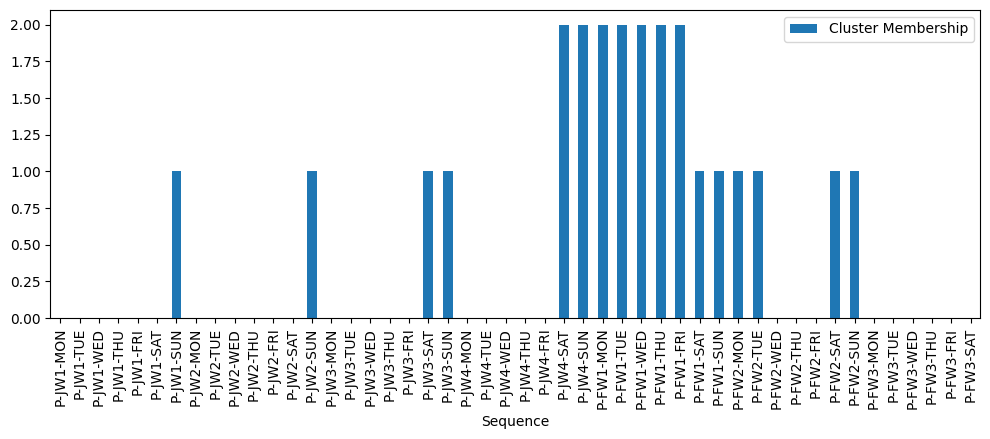

In [10]:
jf_clusters_res.plot(kind='bar',x='Sequence',y='Cluster Membership',figsize=(12,4))

In [11]:
df_times = list(jf_df.index)
tstrip = lambda x:x[:-3]
vtstrip = np.vectorize(tstrip)
fmtd_times = vtstrip(df_times)
fmtd_times

array(['00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30',
       '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15',
       '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00',
       '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45',
       '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30',
       '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15',
       '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00',
       '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45',
       '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30',
       '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15',
       '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00',
       '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45',
       '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30',
       '22:45', '23:00', '23:15', '23:30', '23:45'], dtype='<U5')

In [12]:
#visualizing clusters

def visualize_power_clustering(model,seq_cluster_map,df_with_clusters,fmtd_times):
    fig, axs = plt.subplots(nrows=feeder_k_medoids.n_clusters,ncols=1,figsize=(12,8),sharex=True)

    #plot all traces from the first cluster

    for x in range(0,model.n_clusters):
        cluster_mask = seq_cluster_map['Sequence'][seq_cluster_map['Cluster Membership'] == x].to_list()
        num_members = df_with_clusters[cluster_mask].shape[1]
        axs[x].plot(df_with_clusters[cluster_mask], alpha=0.4,color='#ADD8E6',label='_nolegend_')
        medoid_ID = 'Medoid-'
        medoid_ID += str(x+1)
        axs[x].plot(df_with_clusters[medoid_ID],color='red',label=medoid_ID)
        axs[x].set_xticks(labels=fmtd_times[4::4],ticks=list(range(0, len(df_with_clusters), 4))[:-1])
        axs[x].tick_params(axis='x', labelrotation=60)
        axs[x].grid(which='major',color='lightgrey')
        axs[x].set_ylabel('P/kW')
        if x==model.n_clusters-1:
            axs[x].set_xlabel('Time')
        axs[x].legend()
        cluster_ID = "Cluster "
        cluster_ID += str(x+1)
        cluster_ID += ", members="
        cluster_ID += str(num_members)
        axs[x].set_title(cluster_ID)


def visualize_power_clustering_ensemble(models,seq_cluster_maps,dfs_with_clusters,fmtd_times):
    pass


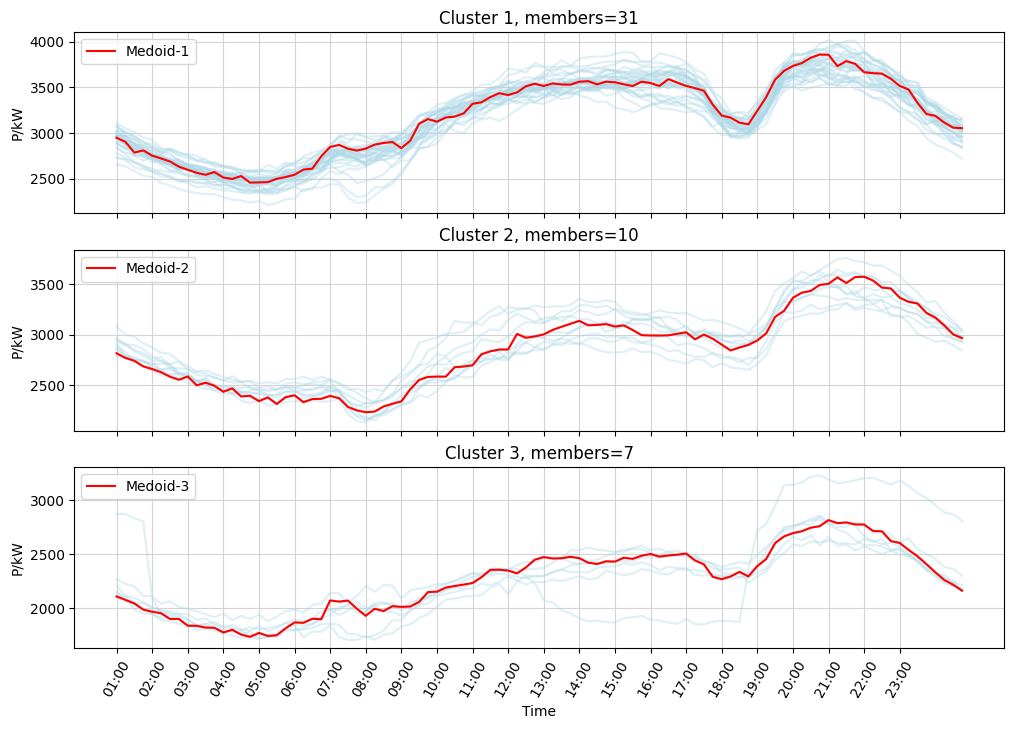

In [13]:
visualize_power_clustering(feeder_k_medoids,jf_clusters_res,jf_df_with_clusters,fmtd_times)

In [14]:
#METRICS


def calculate_silhouette_score(X, labels):
    """
    Calculate the Silhouette score for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Silhouette score.
    """
    return silhouette_score(X, labels)

def calculate_calinski_harabasz_score(X, labels):
    """
    Calculate the Calinski-Harabasz score for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Calinski-Harabasz score.
    """
    return calinski_harabasz_score(X, labels)

def calculate_davies_bouldin_index(X, labels):
    """
    Calculate the Davies-Bouldin index for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Davies-Bouldin index.
    """
    return davies_bouldin_score(X, labels)



def calculate_dunn_index(X, labels):
    """
    Calculate the Dunn Index for a clustering result.

    Parameters:
        X (array-like): Input data points.
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: Dunn Index.
    """
    # Calculate inter-cluster distances
    inter_cluster_distances = pairwise_distances(X)
    inter_cluster_distances = np.max(inter_cluster_distances)

    # Calculate intra-cluster distances
    intra_cluster_distances = []
    for cluster_label in np.unique(labels):
        cluster_points = X[labels == cluster_label]
        if len(cluster_points) > 1:
            intra_cluster_distances.append(np.mean(pairwise_distances(cluster_points)))
    
    # Calculate Dunn Index
    dunn_index = np.min(intra_cluster_distances) / inter_cluster_distances

    return dunn_index

def calculate_fit_scores(X,n_range,metric="euclidean",init_algorithm="kmeans++",max_iter=10):
    '''
    Calculate Silhouette score, Calinski-Harabasz score, 
    Davies-Bouldin index and Dunn Index for a range of 
    K-Mediod models in n_range

    Parameters:
        X (array-like): Input data points
        n_range: Tuple of lower and upper limit for k
    '''

    scores = {  'Silhouette score':[],
                'Calinski-Harabasz Score':[],
                'Davies-Bouldin Index':[],
                'Dunn Index':[]
            }
    models=[]
    for n in range(n_range[0],n_range[1]+1):
        model = TimeSeriesKMedoids(
                            n_clusters=n,  # Number of desired centers
                            init_algorithm=init_algorithm,  # Center initialisation technique
                            max_iter=max_iter,  # Maximum number of iterations for refinement on training set
                            metric=metric,  # Distance metric to use
                            random_state=1,
                        )
        # Predict cluster labels for the input time series
        cluster_labels = model.fit_predict(X)

        # Compute evaluation metrics
        scores['Silhouette score'].append(calculate_silhouette_score(X, cluster_labels))
        scores['Calinski-Harabasz Score'].append(calculate_davies_bouldin_index(X, cluster_labels))
        scores['Davies-Bouldin Index'].append(calculate_calinski_harabasz_score(X, cluster_labels))
        scores['Dunn Index'].append(calculate_dunn_index(X,cluster_labels))
        models.append(model)

    return scores,models


# Quantifying Cluster Quality

In [22]:
# Predict cluster labels for the input time series
cluster_labels = feeder_k_medoids.predict(jf_clust_fmt)

# Compute evaluation metrics
silhouette = calculate_silhouette_score(jf_clust_fmt, cluster_labels)
davies_bouldin = calculate_davies_bouldin_index(jf_clust_fmt, cluster_labels)
calinski_harabasz = calculate_calinski_harabasz_score(jf_clust_fmt, cluster_labels)
dunn_index = calculate_dunn_index(jf_clust_fmt,cluster_labels)

# Print the evaluation metrics
print(f"Silhouette Coefficient: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Dunn Index: {dunn_index}")

Silhouette Coefficient: 0.5895880099371342
Davies-Bouldin Index: 0.5412125644701953
Calinski-Harabasz Index: 183.93732060346787
Dunn Index: 0.12065934561245226


In [23]:
scores,models = calculate_fit_scores(jf_clust_fmt,(2,7),metric="euclidean",init_algorithm="kmeans++",max_iter=10)
scores_df = pd.DataFrame(scores)
scores_df['k'] = np.arange(2,7+1)
scores_df.set_index('k')

,Silhouette score,Calinski-Harabasz Score,Davies-Bouldin Index,Dunn Index
k,,,,
2,0.729709,0.343312,134.229567,0.151278
3,0.589588,0.541213,183.937321,0.120659
4,0.321619,1.017895,141.909748,0.093581
5,0.303619,0.842649,136.183755,0.093211
6,0.278054,0.913773,130.601552,0.093211
7,0.265449,0.889732,117.580950,0.062461


In [24]:
scores_df

,Silhouette score,Calinski-Harabasz Score,Davies-Bouldin Index,Dunn Index,k
0,0.729709,0.343312,134.229567,0.151278,2
1,0.589588,0.541213,183.937321,0.120659,3
2,0.321619,1.017895,141.909748,0.093581,4
3,0.303619,0.842649,136.183755,0.093211,5
4,0.278054,0.913773,130.601552,0.093211,6
5,0.265449,0.889732,117.580950,0.062461,7


## Scoring Clusters against Barycenters used. 

An ensemble of distances will be used to assess how well the medoids differ from the barycenters obtained during preliminary analysis.

In [15]:
jan_feb_df_with_bcs = pd.read_csv('../data/subsequences/jan_and_feb_bcs_P.csv',index_col=0)
jan_feb_df_with_bcs

,P-JW1-MON,P-JW1-TUE,P-JW1-WED,P-JW1-THU,P-JW1-FRI,P-JW1-SAT,P-JW1-SUN,P-JW2-MON,P-JW2-TUE,P-JW2-WED,...,P-FW3-WED,P-FW3-THU,P-FW3-FRI,P-FW3-SAT,P-FW3-SUN,Euclidean Barycenter,Median Barycenter,Modal Barycenter,DTW Barycenter,SDTW Barycenter-G1.0
modified_index,,,,,,,,,,,,,,,,,,,,,
00:00:00,3071.832,2877.704,3014.638,2947.298,2973.446,3029.978,3082.161,2951.033,2840.510,2658.008,...,3109.663,3066.046,3001.912,3083.896,2999.082,2836.342102,2938.459,3071.832,2849.907034,2839.199630
00:15:00,2978.160,2837.915,2927.678,2902.763,2887.630,3002.107,3002.023,2902.292,2765.533,2634.021,...,3051.881,3013.143,2927.982,3008.712,2942.221,2783.213694,2881.016,2978.160,2665.656419,2641.645359
00:30:00,2933.031,2818.541,2821.222,2784.637,2817.670,2967.794,2980.230,2857.068,2684.652,2582.411,...,3007.032,2952.263,2889.920,2962.283,2950.568,2733.294796,2819.613,2933.031,2553.388617,2526.278451
00:45:00,2878.928,2734.480,2781.378,2808.900,2796.380,2906.573,2915.397,2797.825,2629.461,2531.903,...,2948.983,2865.556,2780.830,2900.605,2899.392,2688.062082,2781.378,2878.928,2477.924650,2452.792212
01:00:00,2881.163,2739.832,2710.183,2751.774,2775.842,2857.319,2874.862,2741.989,2614.501,2518.444,...,2929.066,2835.484,2720.138,2835.871,2859.473,2636.481939,2733.304,2881.163,2425.756572,2398.931923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,3253.669,3306.997,3256.090,3207.752,3312.257,3321.875,3320.155,3212.808,2944.720,3206.310,...,3338.875,3341.666,3360.807,3215.341,3321.433,3114.218102,3212.808,3253.669,2996.135044,2994.688919
23:00:00,3135.095,3277.547,3145.562,3187.365,3303.048,3323.098,3331.967,3119.631,2873.001,3152.496,...,3305.466,3297.370,3319.963,3200.933,3249.987,3067.148143,3152.496,3135.095,2996.135044,2994.194928
23:15:00,3096.660,3162.338,3109.879,3114.297,3206.821,3212.273,3219.921,3015.111,2834.910,3066.061,...,3232.459,3195.656,3231.179,3129.438,3128.297,2999.587286,3094.296,3096.660,2995.593871,2993.996972


In [16]:
X = jan_feb_df_with_bcs['Euclidean Barycenter'].to_numpy()
Y = jf_df_with_clusters['Medoid-1'].to_numpy()

### Distance Tests

In [31]:
calculate_correlation(X,Y)

0.9871951676054408

In [32]:
calculate_cross_correlation(X, Y)

922017672.2997301

In [33]:
calculate_euclidean_distance(X, Y)

2230.4662951788414

In [36]:
calculate_dtw_distance(X, Y)

1319.3686627480274

In [37]:
calculate_cosine_similarity(X, Y)

0.9997849422071924

In [38]:
calculate_mutual_information(X, Y)

/home/shankar/miniconda3/envs/gpu_acc/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


4.564348191467836

In [39]:
calculate_lcs_distance(X, Y)

192

In [40]:
calculate_power_spectrum_distance(X, Y)

1167799.2572398575

In [41]:
test_variance(X, Y)

0.00023480301063280088

In [46]:
calculate_relative_entropy(X,Y)

1.0001233635431226

In [54]:
calculate_edit_distance(X, Y, normalized=True)

9.479166666666666

### Hypothesis Tests

In [69]:
a,b = autocorrelation_test(X, Y, alpha=0.05)

In [58]:
waveform_distance_test(X, Y, alpha=0.05)

/tmp/ipykernel_685/1729169461.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = (distance_XY - (distance_XX + distance_YY) / 2) / np.sqrt((distance_XX + distance_YY) / 2)


'Reject the null hypothesis. The waveform distances of the two time series are significantly different.'

In [60]:
kolmogorov_smirnov_test(X, Y, alpha=0.05)

'Reject the null hypothesis. The two time series are significantly different based on the Kolmogorov-Smirnov test.'

In [64]:
spectral_coherence_test(X, Y, 1, alpha=0.05)

'Fail to reject the null hypothesis. The spectral coherence of the two time series is similar.'

In [76]:
a,b = state_space_modeling_test(X, Y, alpha=0.05)

c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Shankar Ramharack\AppData\Local\Temp\ipykernel_8644\4279349892.py:236: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p_value = stats.ttest_ind(aic_X, aic_Y)
c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalar

In [ ]:
feeder_k_medoids.cluster_centers_[1][0]

In [21]:
feeder_k_medoids.n_clusters

3

In [27]:
def test():
    print('WORKS')
    return 2

np.array([test(),test()])

WORKS
WORKS


array([2, 2])

In [ ]:
def score_bc_against_cluster_exmplars(model,barycenters):
    '''
    Computes the similarity ensembles for the 1-to-many map of barycenters to model cluster
    exemplars. This assesses how similar the cluster exemplars are the the averaged 
    barycenters.
    
    Parameters:
        model: The sktime k-partitioning model
        barycenters(array-like): A np-array with the barycenter values as sub-arrays

    Output:
        distance_matrix(array-like): The distance values per ensemble for each mapping
        exemplar_IDs(array-like): A list of exemplar IDs in order of which was used in scoring
        bc_IDs(array-like): A list of barycenter average IDs(names) 
    '''
    hypothesis_tests = []
    distances = []
    bcs_count = barycenters.to_numpy().transpose().shape[0]
    Y_cols = list(barycenters.columns)   

    for i in range(0,model.n_clusters):
        X = model.cluster_centers_[i][0]
        for j in range(0,bcs_count): 
            Y = barycenters.to_numpy().transpose()[j]
            mem_distances = np.array([
                calculate_correlation(X,Y),
                calculate_cross_correlation(X, Y),
                calculate_euclidean_distance(X, Y),
                calculate_dtw_distance(X, Y),
                calculate_cosine_similarity(X, Y),
                calculate_mutual_information(X, Y),
                calculate_lcs_distance(X, Y),
                calculate_power_spectrum_distance(X, Y),
                test_variance(X, Y),
                calculate_relative_entropy(X,Y),
                calculate_edit_distance(X, Y, normalized=True)
            ])
            print('Conducting Hypothesis Tests on BC: {} and Exemplar {}'.format(Y_cols[j],i))
            mem_hypothesis_tests = np.array([
                autocorrelation_test(X, Y, alpha=0.05),
                waveform_distance_test(X, Y, alpha=0.05),
                kolmogorov_smirnov_test(X, Y, alpha=0.05),
                spectral_coherence_test(X, Y, 1, alpha=0.05),
                state_space_modeling_test(X, Y, alpha=0.05)
            ])

            hypothesis_tests.append(mem_hypothesis_tests)
            distances.append(mem_distances)

    distance_names = ['Correlation Distance','Cross Correlation Distance',
                      'euclidean Distance','DTW Distance',
                      'Cosine Similarity Distance','Mutual Information Score',
                      'Longest Common Subsequence Distance' ,'Power Spectrum Distance',
                      'Test Variance','Relative Entropy Distance','Edit Distance']    
    hypothesis_names = ['Autocorrelation test','Waveform Distance Test',
                        'Kolmogorov Smirnov Test','Spectral Coherence Test',
                        'State Space Modelling Test']
    
    hypothesis_df = pd.DataFrame(hypothesis_tests,columns=hypothesis_names)
    distances_df = pd.DataFrame(distances,columns=distance_names)

### Prototyping Scoring

In [19]:
X_full = jan_feb_df_with_bcs[['Euclidean Barycenter','Median Barycenter','Modal Barycenter',	'DTW Barycenter',	
                    'SDTW Barycenter-G1.0']]
list(X_full.columns)

['Euclidean Barycenter',
 'Median Barycenter',
 'Modal Barycenter',
 'DTW Barycenter',
 'SDTW Barycenter-G1.0']

In [ ]:
jan_feb_df_with_bcs[['Euclidean Barycenter']].to_numpy().transpose()

In [31]:
X_full_np = X_full.to_numpy().transpose() #every row of the dataframe now becomes a sub array after to_numpy, hence it needs transposinng.

In [34]:
X_full_np.shape[0]

5

In [36]:
list(X_full.columns)

['Euclidean Barycenter',
 'Median Barycenter',
 'Modal Barycenter',
 'DTW Barycenter',
 'SDTW Barycenter-G1.0']

In [38]:
model = feeder_k_medoids

In [41]:
model.cluster_centers_[0][0]

array([2947.298, 2902.763, 2784.637, 2808.9  , 2751.774, 2720.948,
       2687.773, 2631.081, 2596.491, 2563.827, 2541.956, 2571.585,
       2512.153, 2495.734, 2528.129, 2455.839, 2458.312, 2461.434,
       2497.68 , 2516.718, 2541.944, 2598.541, 2608.73 , 2744.088,
       2846.754, 2868.546, 2827.926, 2806.816, 2828.702, 2872.375,
       2890.043, 2901.17 , 2833.703, 2914.053, 3101.014, 3152.22 ,
       3123.821, 3169.17 , 3179.148, 3214.603, 3319.793, 3335.592,
       3392.92 , 3435.569, 3415.677, 3444.433, 3511.697, 3539.196,
       3514.375, 3542.902, 3531.138, 3529.652, 3561.532, 3567.633,
       3532.281, 3561.742, 3555.526, 3532.761, 3514.289, 3561.873,
       3547.227, 3514.11 , 3590.189, 3551.396, 3515.581, 3490.771,
       3462.3  , 3309.182, 3190.981, 3168.149, 3112.534, 3094.767,
       3243.84 , 3393.714, 3584.038, 3679.629, 3734.62 , 3765.44 ,
       3823.496, 3858.893, 3857.026, 3732.162, 3787.491, 3756.353,
       3665.162, 3655.003, 3650.361, 3594.197, 3515.767, 3475.

In [45]:
X_full_np[0].shape

(96,)

In [46]:
calculate_correlation(X_full_np[0],model.cluster_centers_[0][0])

0.9871951676054408

## P Clustering

In [50]:
model = TimeSeriesKMedoids(
    n_clusters=2,  # Number of desired centers
    init_algorithm="kmeans++",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="euclidean",  # Distance metric to use
    random_state=1,
)
model.fit(X_full_np)

TimeSeriesKMedoids(init_algorithm='kmeans++', max_iter=10, metric='euclidean',
                   n_clusters=2, random_state=1)

In [72]:
hypothesis_tests = []
distances = []
pvals = []
barycenters = X_full
bcs_np =  X_full.to_numpy().transpose()
bcs_count = bcs_np.shape[0]
Y_cols = list(X_full.columns)   

mapping_ids = {}
mapping_itr = 0
for i in range(0,model.n_clusters):
    X = model.cluster_centers_[i][0]
    for j in range(0,bcs_count):
        tmp = "Exemplar"
        tmp += "_"
        tmp += str(i)
        tmp += "-"
        tmp += Y_cols[j]
        mapping_ids[mapping_itr] =  tmp
        Y = bcs_np[j]
        mem_distances = np.array([
            calculate_correlation(X,Y),
            calculate_cross_correlation(X, Y),
            calculate_euclidean_distance(X, Y),
            calculate_dtw_distance(X, Y),
            calculate_cosine_similarity(X, Y),
            calculate_mutual_information(X, Y),
            calculate_lcs_distance(X, Y),
            calculate_power_spectrum_distance(X, Y),
            test_variance(X, Y),
            calculate_relative_entropy(X,Y),
            calculate_edit_distance(X, Y, normalized=True)
        ])

        act_pval,act_str = autocorrelation_test(X, Y, alpha=0.05)
        wfrmxtst_pval,wfrmxtst_str = waveform_distance_test(X, Y, alpha=0.05)
        kstst_pval,kstst_str = kolmogorov_smirnov_test(X, Y, alpha=0.05)
        sptst_pval,sptst_str = spectral_coherence_test(X, Y, 1, alpha=0.05)
        sstst_pval,sstst_str = state_space_modeling_test(X, Y, alpha=0.05)
        mem_hypothesis_tests = np.array([
            act_str,
            wfrmxtst_str,
            kstst_str,
            sptst_str,
            sstst_str
        ])
        mem_hypothesis_tests_pvals = np.array([
            act_pval,
            wfrmxtst_pval,
            kstst_pval,
            sptst_pval,
            sstst_pval
        ])
        
        mapping_itr += 1
        hypothesis_tests.append(mem_hypothesis_tests)
        distances.append(mem_distances)
        pvals.append(mem_hypothesis_tests_pvals)

distance_names = ['Correlation Distance','Cross Correlation Distance',
                    'euclidean Distance','DTW Distance',
                    'Cosine Similarity Distance','Mutual Information Score',
                    'Longest Common Subsequence Distance' ,'Power Spectrum Distance',
                    'Test Variance','Relative Entropy Distance','Edit Distance']    
hypothesis_names = ['Autocorrelation test','Waveform Distance Test',
                    'Kolmogorov Smirnov Test','Spectral Coherence Test',
                    'State Space Modelling Test']

hypothesis_df = pd.DataFrame(hypothesis_tests,columns=hypothesis_names)
distances_df = pd.DataFrame(distances,columns=distance_names)
hypothesis_pvals_df = pd.DataFrame(pvals,columns=hypothesis_names)

c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\Shankar Ramharack\AppData\Local\Temp\ipykernel_8644\4279349892.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = (distance_XY - (distance_XX + distance_YY) / 2) / np.sqrt((distance_XX + distance_YY) / 2)
c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

In [55]:
mapping_ids

{0: 'Exemplar_0-Euclidean Barycenter',
 1: 'Exemplar_0-Median Barycenter',
 2: 'Exemplar_0-Modal Barycenter',
 3: 'Exemplar_0-DTW Barycenter',
 4: 'Exemplar_0-SDTW Barycenter-G1.0',
 5: 'Exemplar_1-Euclidean Barycenter',
 6: 'Exemplar_1-Median Barycenter',
 7: 'Exemplar_1-Modal Barycenter',
 8: 'Exemplar_1-DTW Barycenter',
 9: 'Exemplar_1-SDTW Barycenter-G1.0'}

In [73]:
hypothesis_df

,Autocorrelation test,Waveform Distance Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
1,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
2,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
3,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis. The wavefo...,Fail to reject the null hypothesis. The two ti...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
4,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Fail to reject the null hypothesis. The two ti...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
5,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
6,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis. The wavefo...,Fail to reject the null hypothesis. The two ti...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
7,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
8,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
9,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...


In [74]:
distances_df

,Correlation Distance,Cross Correlation Distance,euclidean Distance,DTW Distance,Cosine Similarity Distance,Mutual Information Score,Longest Common Subsequence Distance,Power Spectrum Distance,Test Variance,Relative Entropy Distance,Edit Distance
0,0.885926,8.120356e+08,2287.944852,696.589055,0.998300,4.000884,192.0,2.363662e+06,2.233367e-03,1.000510,9.645833
1,0.879851,8.485144e+08,3377.196664,834.203352,0.998208,4.000884,192.0,3.588138e+06,6.079173e-08,1.000528,9.510417
2,0.867853,8.825743e+08,4454.935430,1019.133546,0.998358,4.000884,192.0,2.674216e+06,7.817439e-15,1.000222,9.645833
3,1.000000,7.698194e+08,0.000000,0.000000,1.000000,4.000884,0.0,0.000000e+00,1.000000e+00,1.000000,0.000000
4,0.997020,7.685274e+08,235.641916,193.983651,0.999965,4.000884,192.0,1.073973e+05,9.248220e-01,0.999960,8.187500
5,0.993664,8.980901e+08,1386.012921,843.891515,0.999900,4.564348,192.0,1.259848e+06,1.747931e-02,0.999982,9.437500
6,1.000000,9.386148e+08,0.000000,0.000000,1.000000,4.564348,0.0,0.000000e+00,1.000000e+00,1.000000,0.000000
7,0.985971,9.758869e+08,1420.127298,595.155565,0.999736,4.564348,192.0,1.025987e+06,2.178072e-02,0.999694,5.364583
8,0.879851,8.485144e+08,3377.196664,834.203352,0.998208,4.000884,192.0,3.588138e+06,6.079173e-08,0.999472,9.510417
9,0.874827,8.470558e+08,3434.264188,844.384263,0.998133,4.564348,192.0,3.638838e+06,3.338700e-08,0.999432,9.583333


In [75]:
hypothesis_pvals_df

,Autocorrelation test,Waveform Distance Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,1.0,0.0,2.113772e-06,1.0,NaN
1,1.0,0.0,1.811394e-09,1.0,NaN
2,1.0,0.0,9.519306e-13,1.0,NaN
3,1.0,NaN,1.000000e+00,1.0,NaN
4,1.0,0.0,4.432118e-01,1.0,NaN
5,1.0,0.0,5.265596e-04,1.0,NaN
6,1.0,NaN,1.000000e+00,1.0,NaN
7,1.0,0.0,4.801551e-03,1.0,NaN
8,1.0,0.0,1.811394e-09,1.0,NaN
9,1.0,0.0,6.680318e-10,1.0,NaN


## Q Clustering

In [78]:
jan_feb_Q =  pd.read_csv('../data/subsequences/jan_and_feb_daily_Q.csv',index_col=0)
jf_Q_np_arr = jan_feb_Q.to_numpy().transpose()
jf_Q_clust_fmt = jf_Q_np_arr[:-1]

In [79]:
jan_feb_q_df_with_bcs = pd.read_csv('../data/subsequences/jan_and_feb_bcs_Q.csv',index_col=0)
X_q_full = jan_feb_q_df_with_bcs[['Euclidean Barycenter','Median Barycenter','Modal Barycenter',	'DTW Barycenter',	
                    'SDTW Barycenter-G1.0']]

In [80]:
X_q_full_np = X_q_full.to_numpy().transpose() #every row of the dataframe now becomes a sub array after to_numpy, hence it needs transposinng.

In [87]:
model_Q = TimeSeriesKMedoids(
    n_clusters=2,  # Number of desired centers
    init_algorithm="kmeans++",  # Center initialisation technique
    max_iter=10,  # Maximum number of iterations for refinement on training set
    metric="euclidean",  # Distance metric to use
    random_state=1,
)
model_Q.fit(X_q_full_np)

TimeSeriesKMedoids(init_algorithm='kmeans++', max_iter=10, metric='euclidean',
                   n_clusters=2, random_state=1)

In [88]:
hypothesis_tests = []
distances = []
pvals = []
barycenters = X_q_full
bcs_np =  X_q_full.to_numpy().transpose()
bcs_count = bcs_np.shape[0]
Y_cols = list(X_q_full.columns)   

mapping_ids = {}
mapping_itr = 0
for i in range(0,model_Q.n_clusters):
    X = model_Q.cluster_centers_[i][0]
    for j in range(0,bcs_count):
        tmp = "Exemplar"
        tmp += "_"
        tmp += str(i)
        tmp += "-"
        tmp += Y_cols[j]
        mapping_ids[mapping_itr] =  tmp
        Y = bcs_np[j]
        mem_distances = np.array([
            calculate_correlation(X,Y),
            calculate_cross_correlation(X, Y),
            calculate_euclidean_distance(X, Y),
            calculate_dtw_distance(X, Y),
            calculate_cosine_similarity(X, Y),
            calculate_mutual_information(X, Y),
            calculate_lcs_distance(X, Y),
            calculate_power_spectrum_distance(X, Y),
            test_variance(X, Y),
            calculate_relative_entropy(X,Y),
            calculate_edit_distance(X, Y, normalized=True)
        ])

        act_pval,act_str = autocorrelation_test(X, Y, alpha=0.05)
        wfrmxtst_pval,wfrmxtst_str = waveform_distance_test(X, Y, alpha=0.05)
        kstst_pval,kstst_str = kolmogorov_smirnov_test(X, Y, alpha=0.05)
        sptst_pval,sptst_str = spectral_coherence_test(X, Y, 1, alpha=0.05)
        sstst_pval,sstst_str = state_space_modeling_test(X, Y, alpha=0.05)
        mem_hypothesis_tests = np.array([
            act_str,
            wfrmxtst_str,
            kstst_str,
            sptst_str,
            sstst_str
        ])
        mem_hypothesis_tests_pvals = np.array([
            act_pval,
            wfrmxtst_pval,
            kstst_pval,
            sptst_pval,
            sstst_pval
        ])
        
        mapping_itr += 1
        hypothesis_tests.append(mem_hypothesis_tests)
        distances.append(mem_distances)
        pvals.append(mem_hypothesis_tests_pvals)

distance_names = ['Correlation Distance','Cross Correlation Distance',
                    'euclidean Distance','DTW Distance',
                    'Cosine Similarity Distance','Mutual Information Score',
                    'Longest Common Subsequence Distance' ,'Power Spectrum Distance',
                    'Test Variance','Relative Entropy Distance','Edit Distance']    
hypothesis_names = ['Autocorrelation test','Waveform Distance Test',
                    'Kolmogorov Smirnov Test','Spectral Coherence Test',
                    'State Space Modelling Test']

hypothesis_df = pd.DataFrame(hypothesis_tests,columns=hypothesis_names)
distances_df = pd.DataFrame(distances,columns=distance_names)
hypothesis_pvals_df = pd.DataFrame(pvals,columns=hypothesis_names)

c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\Shankar Ramharack\AppData\Local\Temp\ipykernel_8644\4279349892.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = (distance_XY - (distance_XX + distance_YY) / 2) / np.sqrt((distance_XX + distance_YY) / 2)
c:\Users\Shankar Ramharack\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Shankar Ramharack\AppData\Local\Temp\ipykernel_8644\4279349892.py:236: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs wh

In [83]:
hypothesis_df

,Autocorrelation test,Waveform Distance Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
1,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
2,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
3,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis. The wavefo...,Fail to reject the null hypothesis. The two ti...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
4,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Fail to reject the null hypothesis. The two ti...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
5,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
6,Fail to reject the null hypothesis. The autoco...,Fail to reject the null hypothesis. The wavefo...,Fail to reject the null hypothesis. The two ti...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
7,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
8,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...
9,Fail to reject the null hypothesis. The autoco...,Reject the null hypothesis. The waveform dista...,Reject the null hypothesis. The two time serie...,Fail to reject the null hypothesis. The spectr...,Fail to reject the null hypothesis. The state ...


In [84]:
distances_df

,Correlation Distance,Cross Correlation Distance,euclidean Distance,DTW Distance,Cosine Similarity Distance,Mutual Information Score,Longest Common Subsequence Distance,Power Spectrum Distance,Test Variance,Relative Entropy Distance,Edit Distance
0,0.806340,9.800792e+08,2614.505370,861.788331,0.997680,3.913852,192.0,5.314250e+06,3.277432e-03,1.000517,9.697917
1,0.810052,1.008207e+09,3267.893279,1095.909792,0.997642,3.913852,192.0,6.230158e+06,4.316895e-06,1.000564,9.489583
2,0.757775,1.117617e+09,6537.619457,1952.524602,0.997171,3.913852,192.0,8.068358e+06,4.173839e-23,1.000499,9.864583
3,1.000000,9.361895e+08,0.000000,0.000000,1.000000,3.913852,0.0,0.000000e+00,1.000000e+00,1.000000,0.000000
4,0.945192,9.439930e+08,989.445956,417.540884,0.999520,3.913852,192.0,6.647703e+05,5.149221e-01,0.999985,8.708333
5,0.993703,1.060336e+09,1017.499807,670.919936,0.999913,4.564348,192.0,1.092863e+06,9.921984e-02,0.999953,9.218750
6,1.000000,1.090903e+09,0.000000,0.000000,1.000000,4.564348,0.0,0.000000e+00,1.000000e+00,1.000000,0.000000
7,0.966045,1.209304e+09,3752.482526,2204.937207,0.999541,4.564348,192.0,2.021383e+06,5.157384e-09,0.999935,5.937500
8,0.810052,1.008207e+09,3267.893279,1095.909792,0.997642,3.913852,192.0,6.230158e+06,4.316895e-06,0.999436,9.489583
9,0.868942,1.017749e+09,2859.962316,1066.139531,0.998280,4.564348,192.0,6.312450e+06,4.304287e-05,0.999421,9.406250


In [85]:
hypothesis_pvals_df

,Autocorrelation test,Waveform Distance Test,Kolmogorov Smirnov Test,Spectral Coherence Test,State Space Modelling Test
0,1.0,0.0,4.198604e-07,1.0,NaN
1,1.0,0.0,1.811394e-09,1.0,NaN
2,1.0,0.0,1.585416e-20,1.0,NaN
3,1.0,NaN,1.000000e+00,1.0,NaN
4,1.0,0.0,1.391424e-01,1.0,NaN
5,1.0,0.0,9.462810e-04,1.0,NaN
6,1.0,NaN,1.000000e+00,1.0,NaN
7,1.0,0.0,7.560231e-08,1.0,NaN
8,1.0,0.0,1.811394e-09,1.0,NaN
9,1.0,0.0,1.811394e-09,1.0,NaN


In [90]:
#assigning cluster series to original dataframe
q_cluster_df = pd.DataFrame(data={'Medoid-1':model_Q.cluster_centers_[0][0],
                                'Medoid-2':model_Q.cluster_centers_[1][0]})
jan_feb_Q_with_clusters = pd.concat([jan_feb_Q,q_cluster_df],axis=1)                                
q_cluster_df.set_index(jan_feb_Q.index,inplace=True)          

seq_cluster_map_q = pd.DataFrame(data={'Sequence':np.array(jan_feb_Q.columns[:-1]),'Cluster Membership':model_Q.labels_})
visualize_power_clustering(model_Q,seq_cluster_map_q,jan_feb_Q_with_clusters,fmtd_times)

ValueError: All arrays must be of the same length

# Future Work

This seems like an interesting appraoch to cluster the elements and provide implicit scoring, I will look into it more after the work. Furthermore, I should also look at K-Mediod Stability to improve my confidence whether the true number of cluster(s) and center(s) are found. This is a bootstrapping approach and has quite alot of benefit compared to the scores I use.

In [24]:
%pip install minisom

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10601 sha256=3912ed5f8fa9dd8e45a6a2cdf174de585d0a80ddd41105d7bef7baf04bd3f4b5
  Stored in directory: c:\users\shankar ramharack\appdata\local\pip\cache\wheels\c7\92\d2\33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load ElectricDevices dataset
data = np.loadtxt('../data/misc/ElectricDevices/ElectricDevices_TRAIN.txt')

# Normalize the dataset
data = (data - np.mean(data)) / np.std(data)

# Define SOM parameters
grid_size = 10
input_len = data.shape[1]
sigma = 1.0
learning_rate = 0.5
num_epochs = 100

# Train the SOM
som = MiniSom(grid_size, grid_size, input_len, sigma=sigma, learning_rate=learning_rate)
som.random_weights_init(data)
som.train_batch(data, num_epochs)

# Map time series to SOM grid
mapped_data = som.quantization(data)

# Compute cluster labels
cluster_labels = np.argmax(mapped_data, axis=1)

# Visualize SOM grid and clustered time series
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

for i, time_series in enumerate(data):
    winner_coordinates = som.winner(time_series)  # Get the coordinates of the winning node for each time series
    plt.plot(winner_coordinates[1] + 0.5, winner_coordinates[0] + 0.5, 'o', color='C{}'.format(cluster_labels[i]), alpha=0.6)

plt.title('SOM Clustering - ElectricDevices Dataset')
plt.show()
